In [1]:
import pylab
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import algorithms as algo

In [2]:
import pandas as pd
dataset='datasets/export'
files = ["L185_0_A9_1", "L185_0_A10_1", "L186_0_A11_1","L186_0_A12_1",
         "L187_0_B1_1", "L187_0_B2_1",  "L291_0_A1_1", "L291_0_A2_1",
        ]
i = 2
print(f"{dataset}/{files[i]}.txt")
df= pd.read_table(f"{dataset}/{files[i]}.txt",
                  sep=" ", 
                  header=None,
                  names=['m/z', 'intensity']) 
df.head()

datasets/export/L186_0_A11_1.txt


,m/z,intensity
0,997.552,6966
1,997.646,6942
2,997.741,7003
3,997.836,7068
4,997.931,7122


In [3]:
x = df['m/z'].to_numpy()
y = df['intensity'].to_numpy()
print(x[:5])
print(y[:5])

[997.552 997.646 997.741 997.836 997.931]
[6966 6942 7003 7068 7122]


# SciPy: scipy.signal.find_peaks
- `height` : Required height of peaks.
- `distance`: Required threshold of peaks, the vertical distance to its neighboring samples.
- `prominence`: Required minimal horizontal distance (>= 1) in samples between neighbouring peaks
- `threshold` : Required prominence of peaks.
- `width`: Required width of peaks in samples
- `wlen` : Used for calculation of the peaks prominences, if one of `prominence` or `width` is given.
- `rel_height`: Used for calculation of the peaks width, if `width` is given.
- `plateau_size`: Required size of the flat top of peaks in samples.

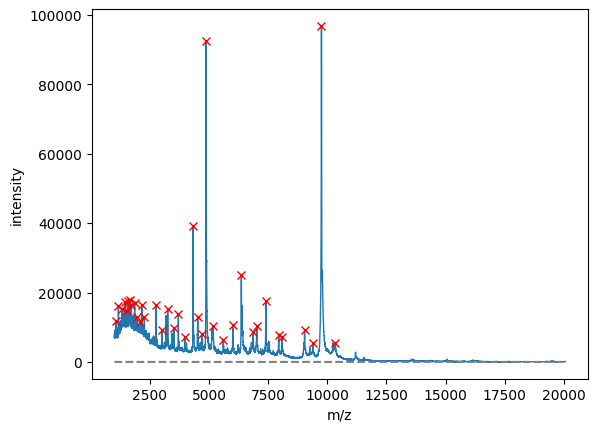

In [4]:
# 基本的Peak検出

dist, prom = 500, 3000
peaks,_ = signal.find_peaks(y, distance=dist, prominence=prom)
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, y, lw=1)
plt.plot(x[peaks], y[peaks], "rx")
plt.plot(x,np.zeros_like(y), "--", color="gray")
plt.show()

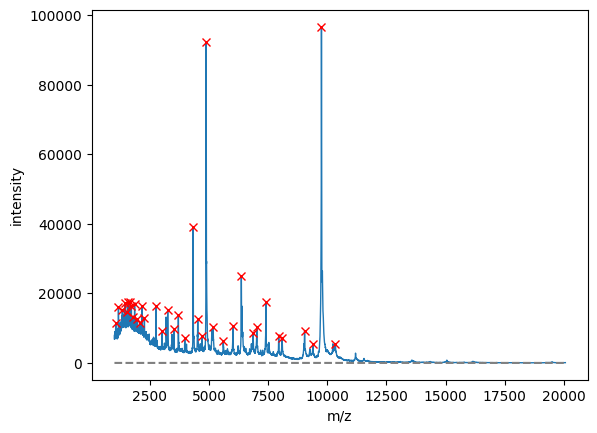

In [5]:
# 平滑化を適用

window = 15
deg = 2   
smoothed = signal.savgol_filter(y, window, deg, deriv=0)
peaks,_ = signal.find_peaks(smoothed, distance=dist, prominence=prom)

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, smoothed, lw=1)
plt.plot(x[peaks], smoothed[peaks], "rx")
plt.plot(x, np.zeros_like(y), "--", color="gray")
plt.show()

# Baseline Correction

## pybaselines · PyPI
cf. https://github.com/derb12/pybaselines <br> 
A Python library of algorithms for the baseline correction of experimental data. `pybaselines` has 50+ baseline correction algorithms. 
- Polynomial methods (`pybaselines.polynomial`), 
- Whittaker-smoothing-based methods (`pybaselines.whittaker`), 
- Morphological methods (`pybaselines.morphological`), 
- Spline methods (`pybaselines.spline`) 
- Smoothing-based methods (`pybaselines.smooth`)
- Baseline/Peak Classification methods (`pybaselines.classification`)
- Optimizers (`pybaselines.optimizers`)
- Miscellaneous methods (`pybaselines.misc`)

In [6]:
from pybaselines import Baseline, utils
# Erb, D. (2022). pybaselines: A Python library of algorithms for the baseline correction of experimental data. 
# https://doi.org/10.5281/zenodo.5608581.

In [7]:
# 様々なBaseline補正

baseline_fitter = Baseline(x_data=x)
bkg_1 = baseline_fitter.modpoly(y, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(y, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(y, half_window=30)[0]
bkg_4 = baseline_fitter.snip(
    y, max_half_window=40, decreasing=True, smooth_half_window=3
)[0]

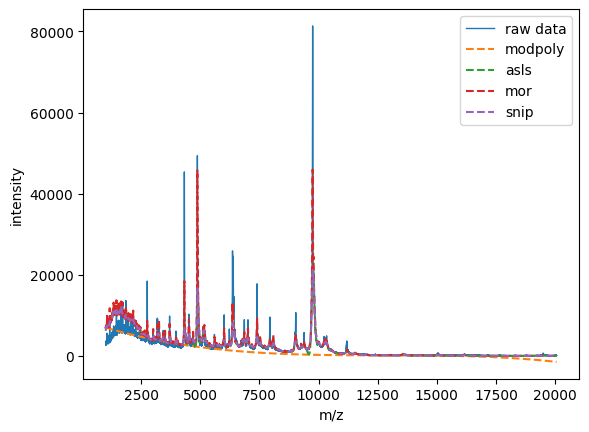

In [27]:
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, y, label='raw data', lw=1)
plt.plot(x, bkg_1, '--', label='modpoly')
plt.plot(x, bkg_2, '--', label='asls')
plt.plot(x, bkg_3, '--', label='mor')
plt.plot(x, bkg_4, '--', label='snip')
plt.legend()
plt.show()

total peaks=33


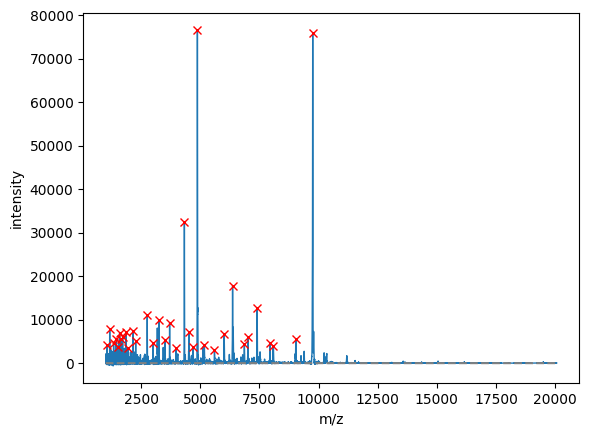

In [9]:
# Baseline補正を適用したPeak検出

dist, prom = 500, 3000
z =  y - bkg_4
peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)
print(f"total peaks={len(peaks)}")
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, z, lw=1)
plt.plot(x[peaks], z[peaks], "rx")
plt.plot(x,np.zeros_like(z), "--", color="gray")
plt.show()

In [10]:
for s in range(0,12000,3000):
    n = len([p for p in peaks if s < x[p] < s+3000])
    print(f"[{s},{s+3000}]\t peaks = {n}")

[0,3000]	 peaks = 13
[3000,6000]	 peaks = 11
[6000,9000]	 peaks = 7
[9000,12000]	 peaks = 2


In [11]:
# すべてのデータセットに対して、Peak検出を行う。
# pybaselinesによるBaseline補正
# 結果をpeaks_indという辞書に保存する

peaks_in = dict()
for file in files:
#     print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    window = 15
    deg = 2   
    smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    base_filter = Baseline(x_data=x)
    bkg = base_filter.asls(y, lam=1e7, p=0.02)[0]
    z = smoothed - bkg
    peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)
    
    peaks_in[file] = (x[peaks], z[peaks]) 
#     plt.xlabel("m/z")
#     plt.ylabel("intensity")
#     plt.plot(x, z)
#     plt.plot(x[peaks], z[peaks], "rx")
#     plt.plot(x, np.zeros_like(y), "--", color="gray")
#     plt.show()

In [12]:
for k in peaks_in:
    print(f'{k}のPeak数:\t{len(peaks_in[k][0])}')

L185_0_A9_1のPeak数:	40
L185_0_A10_1のPeak数:	39
L186_0_A11_1のPeak数:	34
L186_0_A12_1のPeak数:	30
L187_0_B1_1のPeak数:	20
L187_0_B2_1のPeak数:	23
L291_0_A1_1のPeak数:	11
L291_0_A2_1のPeak数:	26


In [13]:
# m/zの値は精確ではないため、下記の関数で結果を丸める
def fmt(f, d=1):
    """ 実数を整数に丸める。d:桁数 d桁以内四捨五入 
       例：fmt(3456.78,d=1) == 3460, fmt(3456.78,d=2) == 3500
    """
    return round(int(f), -d)

def pik(pk,d=1):
    """ Peaksのm/z値を丸め、辞書にして返す
    """
    npk =  ([fmt(x,d=d) for x in pk[0]],pk[1]) # m/zを丸める
    return dict(zip(npk[0], npk[1]))

In [14]:
# 共通Peak数を調べる

data = []
n = len(files)
for i in range(n-1):
    p1,p2 = files[i], files[i+1]
    pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
    c = len(pk1.keys() & pk2.keys())
    print(f'{p1}と{p2}の共通Peak数:\t{c}')

L185_0_A9_1とL185_0_A10_1の共通Peak数:	30
L185_0_A10_1とL186_0_A11_1の共通Peak数:	30
L186_0_A11_1とL186_0_A12_1の共通Peak数:	27
L186_0_A12_1とL187_0_B1_1の共通Peak数:	17
L187_0_B1_1とL187_0_B2_1の共通Peak数:	18
L187_0_B2_1とL291_0_A1_1の共通Peak数:	11
L291_0_A1_1とL291_0_A2_1の共通Peak数:	10


In [15]:
from BaselineRemoval import BaselineRemoval

In [16]:
# すべてのデータセットに対して、Peak検出を行う。
#  BaselineRemovalによるBaseline補正
# 結果をpeaks_indという辞書に保存する

peaks_in = {}
for file in files:
#     print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    window = 15
    deg = 2   
    smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    brm = BaselineRemoval(smoothed)    
    z = brm.ZhangFit(lambda_=100,repitition=15, porder=1)
    peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)

    peaks_in[file] = (x[peaks], z[peaks]) 
#     plt.xlabel("m/z")
#     plt.ylabel("intensity")
#     plt.plot(x, z)
#     plt.plot(x[peaks], z[peaks], "rx")
#     plt.plot(x, np.zeros_like(y), "--", color="gray")
#     plt.show()

for k in peaks_in:
    print(f'{k}のPeak数:\t{len(peaks_in[k][0])}')

L185_0_A9_1のPeak数:	39
L185_0_A10_1のPeak数:	36
L186_0_A11_1のPeak数:	32
L186_0_A12_1のPeak数:	29
L187_0_B1_1のPeak数:	19
L187_0_B2_1のPeak数:	23
L291_0_A1_1のPeak数:	10
L291_0_A2_1のPeak数:	27


In [17]:
# 共通Peak数を調べる

data = []
n = len(files)
for i in range(n-1):
    p1,p2 = files[i], files[i+1]
    pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
    c = len(pk1.keys() & pk2.keys())
    print(f'{p1}と{p2}の共通Peak数:\t{c}')


L185_0_A9_1とL185_0_A10_1の共通Peak数:	29
L185_0_A10_1とL186_0_A11_1の共通Peak数:	29
L186_0_A11_1とL186_0_A12_1の共通Peak数:	25
L186_0_A12_1とL187_0_B1_1の共通Peak数:	16
L187_0_B1_1とL187_0_B2_1の共通Peak数:	17
L187_0_B2_1とL291_0_A1_1の共通Peak数:	10
L291_0_A1_1とL291_0_A2_1の共通Peak数:	9


In [18]:
# 類似度計算
def jacard(pk1, pk2, weighted=False):
    """ Jacard Similarity
    """
    c =  pk1.keys() & pk2.keys()
    d1 = pk1.keys() - pk2.keys()
    d2 = pk2.keys() - pk1.keys()
    n = len(c) + len(d1) + len(d2)
    return len(c)/ float(n)

def prominence(f1, f2):
    delta = min(f1,f2)/ (abs(f1 - f2)+1) 
    weight = (f1 + f2)/2
    return delta * weight

prominence(1234.56, 1234)

976347.1282051624

In [26]:
# Jacard Similarity 

n = len(files)
print('Jacard Similarity:')
rs = []
for i in range(n-1):
    for j in range(i+1, n):
        p1,p2 = files[i], files[j]
        pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
#         print(f'{p1},\t{p2}:{jacard(pk1, pk2)}')
        rs += [(i,j,jacard(pk1, pk2))]

for i,j,score in sorted(rs, key=lambda x: x[2], reverse=True):
    print(f'{ files[i]} & \t{ files[j]}:\t {score:.4f}')

Jacard Similarity:
L185_0_A10_1 & 	L186_0_A11_1:	 0.7436
L185_0_A10_1 & 	L186_0_A12_1:	 0.7105
L186_0_A11_1 & 	L186_0_A12_1:	 0.6944
L187_0_B1_1 & 	L187_0_B2_1:	 0.6800
L187_0_B2_1 & 	L291_0_A2_1:	 0.6667
L186_0_A11_1 & 	L291_0_A2_1:	 0.6389
L185_0_A9_1 & 	L185_0_A10_1:	 0.6304
L186_0_A12_1 & 	L187_0_B2_1:	 0.6250
L185_0_A9_1 & 	L186_0_A12_1:	 0.6190
L186_0_A12_1 & 	L291_0_A2_1:	 0.6000
L187_0_B1_1 & 	L291_0_A2_1:	 0.5862
L185_0_A10_1 & 	L291_0_A2_1:	 0.5750
L185_0_A9_1 & 	L186_0_A11_1:	 0.5435
L186_0_A11_1 & 	L187_0_B2_1:	 0.5278
L187_0_B1_1 & 	L291_0_A1_1:	 0.5263
L185_0_A9_1 & 	L291_0_A2_1:	 0.5000
L186_0_A12_1 & 	L187_0_B1_1:	 0.5000
L185_0_A10_1 & 	L187_0_B2_1:	 0.4750
L185_0_A9_1 & 	L187_0_B1_1:	 0.4500
L187_0_B2_1 & 	L291_0_A1_1:	 0.4348
L186_0_A11_1 & 	L187_0_B1_1:	 0.4167
L185_0_A9_1 & 	L187_0_B2_1:	 0.4091
L185_0_A10_1 & 	L187_0_B1_1:	 0.3750
L291_0_A1_1 & 	L291_0_A2_1:	 0.3214
L186_0_A12_1 & 	L291_0_A1_1:	 0.3000
L186_0_A11_1 & 	L291_0_A1_1:	 0.2727
L185_0_A9_1 & 	L291_0_A1_